# parPE Raia example model

In [1]:
import amici
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
from importlib import reload

In [2]:
# set paths
parpe_source_root = os.path.abspath('../../../')
parpe_build_root = os.path.join(parpe_source_root, 'build') 

model_source_dir = f'{parpe_build_root}/amici/examples/raia/raia-prefix/src/raia/raia'
example_binary_dir = f'{parpe_build_root}/amici/raia/raia/'
example_data_dir = f'{parpe_build_root}/amici/examples/raia/raia-prefix/src/raia'
optimizationOptionsPy = f'{parpe_source_root}/misc/optimizationOptions.py'

# load parpe module from source tree
sys.path.insert(0, os.path.join(parpe_source_root, 'python'))
import parpe

# rebuild example
!cd {parpe_build_root} && make

-- Found Git: /usr/bin/git (found version "2.17.1") 
-- Building version parPE-v0.2.0-27-g25cf-dirty
[  0%] Built target get_version
[  7%] Built target parpecommon
[  9%] Built target parpeloadbalancer
[ 17%] Built target parpeoptimization
[ 25%] Built target parpeamici
[ 26%] Built target parpe
[ 30%] Built target unittests_common
[ 34%] Built target unittests_optimization_ipopt
[ 41%] Built target unittests_optimization
[ 44%] Built target unittests_optimization_ceres
[ 47%] Built target unittests_loadbalancer
[ 48%] Built target example_loadbalancer
[ 56%] Built target steadystate_scaled
[ 59%] Built target example_steadystate
[ 63%] Built target example_steadystate_parallel
[ 65%] Built target example_steadystate_multi
[ 68%] Built target example_steadystate_multi_simulator
[ 72%] Built target test_steadystate
[ 79%] Built target lucarelli_12
[ 81%] Built target estimateLucarelli
[ 83%] Built target simulateLucarelli
[ 90%] Built target raia
[ 92%] Built target estimateRaia
[ 93%]

## Test simulation

In [3]:
def plotStateTrajectories(rdata):
    for ix in range(0,rdata['x'].shape[1]):
        plt.plot(rdata['t'], rdata['x'][:, ix], label='$x_%d$' % ix)
        plt.xlabel('$t$ (s)')
        plt.ylabel('$x_i(t)$ (mmol/ml)')
        plt.legend()
        plt.title('State trajectories')
    plt.show()
    
def plotObservableTrajectories(rdata):
    for iy in range(rdata['y'].shape[1]):
        plt.plot(rdata['t'], rdata['y'][:, iy], label='$y_%d$' % iy)
        plt.xlabel('$t$ (s)')
        plt.ylabel('$y_i(t)$ (AU)')
        plt.legend()
        plt.title('Observables')
    
    plt.show()


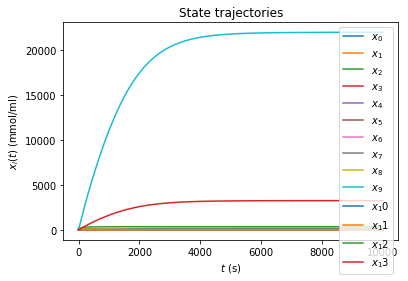

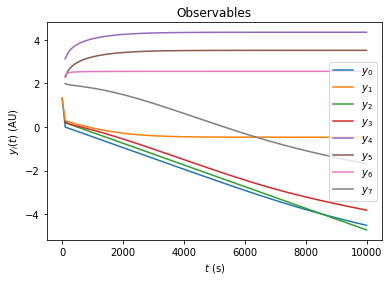

In [4]:
# load model
sys.path.insert(0, model_source_dir)
import raia as modelModule

model = modelModule.getModel()
model.setTimepoints(amici.DoubleVector(np.linspace(0, 100, 100))) 
solver = model.getSolver()
rdata = amici.runAmiciSimulation(model, solver)

default_parameters = np.array(model.getParameters())
plotStateTrajectories(rdata)
plotObservableTrajectories(rdata)


## Prepare parameter estimation with minibatch optimizer

- Load simulated data
- Edit optimization options

In [5]:
input_file = f'{example_data_dir}/example_data.h5'
!../../../misc/optimizationOptions.py {input_file} -s numStarts 1
!../../../misc/optimizationOptions.py {input_file} -s hierarchicalOptimization 0
!../../../misc/optimizationOptions.py {input_file} -s optimizer 10 # minibatch
!../../../misc/optimizationOptions.py {input_file} -s minibatch/maxEpochs 5
!../../../misc/optimizationOptions.py {input_file} -s minibatch/batchSize 1
!../../../misc/optimizationOptions.py {input_file} -s minibatch/parameterUpdater Vanilla
!../../../misc/optimizationOptions.py {input_file} -s minibatch/learningRateInterpMode linear
!../../../misc/optimizationOptions.py {input_file} -s minibatch/rescueInterceptor 0
!../../../misc/optimizationOptions.py {input_file} -s retryOptimization 0
!../../../misc/optimizationOptions.py {input_file}

                hierarchicalOptimization            0
                               numStarts            1
                               optimizer           10
                       retryOptimization            0
                ceres/max_num_iterations          100
                         fmincon/GradObj        b'on'
                     fmincon/MaxFunEvals   10000000.0
                         fmincon/MaxIter          100
                          fmincon/TolFun            0
                            fmincon/TolX        1e-08
                       fmincon/algorithm b'interior-point'
                         fmincon/display      b'iter'
                   ipopt/acceptable_iter            1
         ipopt/acceptable_obj_change_tol        1e-12
                    ipopt/acceptable_tol        1e+20
             ipopt/hessian_approximation b'limited-memory'
        ipopt/limited_memory_update_type      b'bfgs'
                          ipopt/max_iter          100
                  

## Rebuild executables

In [6]:
!pwd
!(cd {parpe_build_root} && exec make -j12)
!rm -rf deleteme

/home/paul/Documents/parpe/parPE/amici/examples/raia
-- Found Git: /usr/bin/git (found version "2.17.1") 
[  7%] Built target parpecommon
-- Building version parPE-v0.2.0-27-g25cf-dirty
[  7%] Built target get_version
[  9%] Built target parpeloadbalancer
[ 13%] Built target unittests_common
[ 21%] Built target parpeoptimization
[ 22%] Built target example_loadbalancer
[ 25%] Built target unittests_loadbalancer
[ 33%] Built target parpeamici
[ 36%] Built target unittests_optimization_ceres
[ 40%] Built target unittests_optimization_ipopt
[ 47%] Built target unittests_optimization
[ 54%] Built target lucarelli_12
[ 62%] Built target steadystate_scaled
[ 69%] Built target raia
[ 70%] Built target parpe
[ 77%] Built target unittests_amici
[ 83%] Built target example_steadystate_parallel
[ 83%] Built target estimateLucarelli
[ 85%] Built target estimateRaia
[ 88%] Built target example_steadystate
[ 92%] Built target example_steadystate_multi_simulator
[ 89%] Built target simulateRaia
[ 94%

## Minibatch optimization

In [7]:
!mpiexec -np 4 ../../../build/amici/examples/raia/estimateRaia -o deleteme-minibatch/ {input_file}

[2019-01-24 13:29:33] [DBG] [3/paul-ubuntu] Rank 3/4 running on paul-ubuntu.
[2019-01-24 13:29:33] [DBG] [3/paul-ubuntu] Seeding RNG with 1548332973
[2019-01-24 13:29:33] [DBG] [1/paul-ubuntu] Rank 1/4 running on paul-ubuntu.
[2019-01-24 13:29:33] [DBG] [1/paul-ubuntu] Seeding RNG with 1548332973
[2019-01-24 13:29:33] [DBG] [2/paul-ubuntu] Rank 2/4 running on paul-ubuntu.
[2019-01-24 13:29:33] [DBG] [2/paul-ubuntu] Seeding RNG with 1548332973
[2019-01-24 13:29:33] [INF] [0/paul-ubuntu] Running with 4 MPI processes.
[2019-01-24 13:29:33] [DBG] [0/paul-ubuntu] Rank 0/4 running on paul-ubuntu.
[2019-01-24 13:29:33] [DBG] [0/paul-ubuntu] Seeding RNG with 1548332973
[2019-01-24 13:29:33] [INF] [0/paul-ubuntu] Reading options and data from '/home/paul/Documents/parpe/parPE/build/amici/examples/raia/raia-prefix/src/raia/example_data.h5'.
[2019-01-24 13:29:33] [DBG] [0/paul-ubuntu] Starting runParallelMultiStartOptimization with 1 starts
[2019-01-24 13:29:33] [INF] [0/paul-ubuntu] Reading rand

[2019-01-24 13:34:46] [WRN] [1/paul-ubuntu] [AMICI:mex:CVODES:CVode:TOO_MUCH_WORK] AMICI ERROR: in module CVODES in function CVode : At t = 31.4555, mxstep steps taken before reaching tout. 
[2019-01-24 13:34:46] [WRN] [1/paul-ubuntu] [AMICI:mex:CVODEA:CVodeB:TOO_MUCH_WORK] AMICI ERROR: in module CVODEA in function CVodeB : Error occured while integrating backward problem # 0 
[2019-01-24 13:34:46] [WRN] [1/paul-ubuntu] [AMICI:mex:simulation] AMICI backward simulation failed when trying to solve until t = 25.000000 (see message above):
AMICI failed to integrate the backward problem

[2019-01-24 13:34:46] [WRN] [1/paul-ubuntu] [o0e0b0c2] Error during simulation (try 9/10), retrying with relaxed error tolerances (*= 1000): abs: 1e-16 rel: 1e-08 quadAbs: 1e+15 quadRel: 1e+19 abs_asa: 1e+11, rel_asa: 1e+19
[2019-01-24 13:35:20] [WRN] [1/paul-ubuntu] [AMICI:mex:CVODES:CVode:TOO_MUCH_WORK] AMICI ERROR: in module CVODES in function CVode : At t = 31.4555, mxstep steps taken before reaching to

## IpOpt optimization

In [ ]:
# enable derivate checker
#!../../../misc/optimizationOptions.py {hdf5File} -s ipopt/derivative_test first-order
#!../../../misc/optimizationOptions.py {hdf5File} -s ipopt/derivative_test_print_all yes
!../../../misc/optimizationOptions.py {hdf5File} -s numStarts 1
!../../../misc/optimizationOptions.py {hdf5File} -s hierarchicalOptimization 0
!../../../misc/optimizationOptions.py {hdf5File}

In [ ]:
!PARPE_MAX_SIMULATIONS_PER_PACKAGE=1 mpiexec -np 4 ../../../build/amici/examples/lucarelli/estimateLucarelli -o deleteme/ example_data.h5


In [ ]:
filename = 'deleteme/_rank00000.h5'
with h5py.File(filename, 'r') as f:
    trajectory = f['/multistarts/0/iterCostFunCost'][:]
for start in range(trajectory.shape[0]):
    plt.plot(trajectory[start])
trajectory

## Compare results

In [ ]:
def compareResults(filename, expectedNllh):
    with h5py.File(filename, 'r') as f:
        final_parameters = f['/multistarts/0/finalParameters'][:]
        exit_status = f['/multistarts/0/exitStatus'][:]
        final_cost = f['/multistarts/0/finalCost'][:]

    for i, p in enumerate(pscale):
        if p == 2:
            final_parameters[i] = np.power(10, final_parameters[i])

    print("#  __Exp___ __Act___ __Err___ _RelErr___")
    for i in range(len(true_parameters)):
        error = final_parameters[i]-true_parameters[i]
        rel_error = error / true_parameters[i]
        print('%d: %6f %6f %6f %6f' % (i, true_parameters[i], 
                                       final_parameters[i], 
                                       error,rel_error))
    print('Status: %d' % exit_status)
    print('Cost: %f (expected: %f)' % (final_cost, expectedNllh))

In [ ]:
compareResults('deleteme-minibatch/_rank-0001.h5', -expectedLlh)

In [ ]:
!pwd

In [ ]:
!rm sim.h5
!../../../build/amici/examples/lucarelli/simulateLucarelli deleteme/_rank-0001.h5 / sim.h5 / --at-optimum

In [ ]:
with h5py.File('sim.h5', 'r') as f:
    ysim = f['/multistarts/0/ySim'][:]
    ymes = f['/multistarts/0/yMes'][:]
print(ysim.shape)
print(ymes.shape)

In [ ]:
def plotCorrelation(ymes, ysim):
    for iy in range(ysim.shape[2]):
        fig, ax = plt.subplots()
        for icondition in range(ysim.shape[0]):
            x = ymes[icondition, :, iy]
            y = ysim[icondition, :, iy]
            print(x, y)
            ax.scatter(x, y, label='$y_%d$ condition %d' % (iy, icondition))
        plt.xlabel('measurement (AU)')
        plt.ylabel('simulation (AU)')
        plt.gca().set_aspect('equal', adjustable='box')
        plt.title('Observable %d' % iy)
        plt.legend()
        plt.show()
        
plotCorrelation(ymes, ysim)

In [ ]:
def plotTrajectoryFit(ymes, ysim, timepoints):
    for icondition in range(ysim.shape[0]):
        fig, ax = plt.subplots()
        for iy in range(ysim.shape[2]):
            ax.plot(timepoints, ysim[icondition, :, iy], label='$y_%d$ sim' % (iy), alpha=0.7, c='C%d'%iy)
            ax.plot(timepoints, ymes[icondition, :, iy], label='$y_%d$ mes' % (iy), linestyle='dotted', c='C%d'%iy)
        plt.xlabel('$t$ (s)')
        plt.ylabel('$y_i(t)$ (AU)')
        plt.title('Condition %d' %icondition)
        plt.legend()
        plt.show()

plotTrajectoryFit(ymes, ysim, timepoints)